# Analyzing the data

In [ ]:
import pandas as pd
import numpy as np

rawData = pd.read_csv('../data/transactional-sample.csv', dtype={
    'transaction_id': int,
    'merchant_id': int,
    'user_id': int,
    'card_number': str,
    'transaction_date': str,
    'transaction_amount': float,
    'device_id': str,
    'has_cbk': str
    })

# General fraud data
fraud_percentage = (rawData['has_cbk'].value_counts(normalize=True) * 100).loc['TRUE']
print(f"\nPercentage of frauds: {fraud_percentage:.2f}%")
print(rawData['has_cbk'].value_counts())


Percentage of frauds: 12.22%
FALSE    2808
TRUE      391
Name: has_cbk, dtype: int64


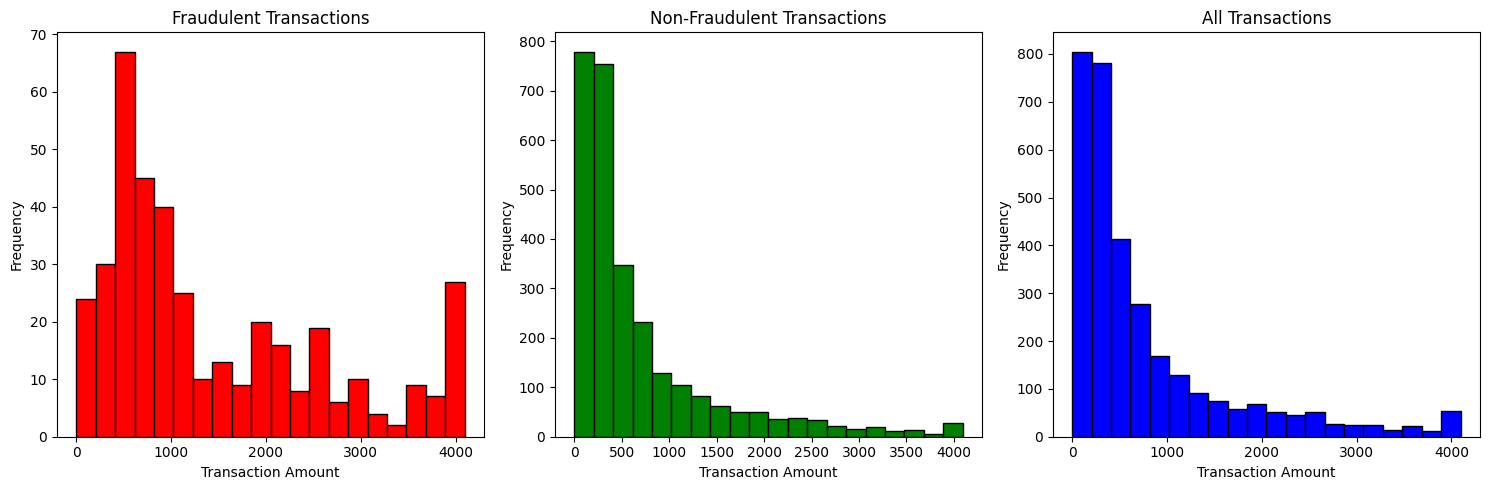

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram for fraudulent transactions
axes[0].hist(rawData[rawData['has_cbk'] == 'TRUE']['transaction_amount'], bins=20, color='red', edgecolor='black')
axes[0].set_title('Fraudulent Transactions')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')

# Histogram for non-fraudulent transactions
axes[1].hist(rawData[rawData['has_cbk'] == 'FALSE']['transaction_amount'], bins=20, color='green', edgecolor='black')
axes[1].set_title('Non-Fraudulent Transactions')
axes[1].set_xlabel('Transaction Amount')
axes[1].set_ylabel('Frequency')

# Histogram for all transactions
axes[2].hist(rawData['transaction_amount'], bins=20, color='blue', edgecolor='black')
axes[2].set_title('All Transactions')
axes[2].set_xlabel('Transaction Amount')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

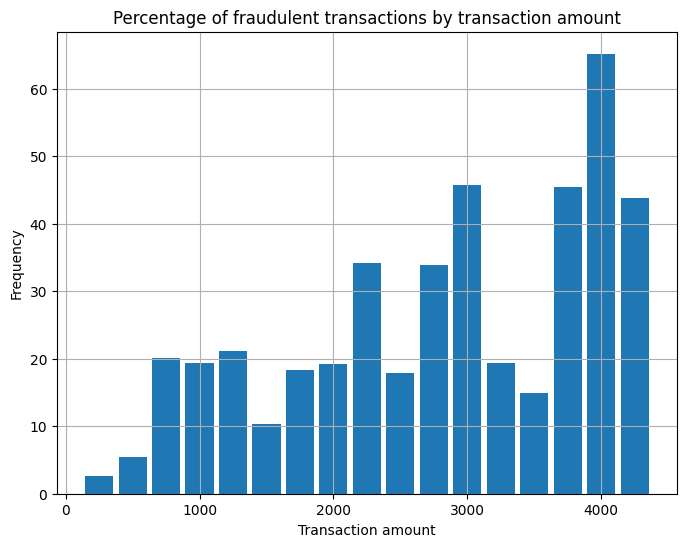

In [ ]:
# Identifying whcih transactions are most likely to be fraudulent
bin_size = 250
num_bins = int(np.ceil(rawData['transaction_amount'].max() / bin_size))
fraud_percentage_array = np.zeros(num_bins)
xvals = []
yvals = []

# Calculate the percentage of fraud for each bin
for i in range(num_bins):
  lower_bound = i * bin_size
  upper_bound = (i + 1) * bin_size
  bin_data = rawData[(rawData['transaction_amount'] >= lower_bound) & (rawData['transaction_amount'] < upper_bound)]

  if len(bin_data) > 0:
    fraud_percentage = (bin_data['has_cbk'] == 'TRUE').mean() * 100
    fraud_percentage_array[i] = fraud_percentage

for i in range(num_bins):
  xvals.append((i + 1) * bin_size)
  yvals.append(fraud_percentage_array[i])

plt.figure(figsize=(8, 6))
plt.bar(xvals, yvals, width=210)
plt.xlabel('Transaction amount')
plt.ylabel('Frequency')
plt.title('Percentage of fraudulent transactions by transaction amount')
plt.grid(True)
plt.show()


Specific cases analysis

In [ ]:
# Identifying fraudulent [field] function
def getCbkStats(fieldName):
  fraud_data = rawData[rawData['has_cbk'] == 'TRUE']
  cbk_amount = fraud_data.groupby(fieldName)['has_cbk'].count().reset_index()

  no_fraud_data = rawData[rawData['has_cbk'] == 'FALSE']

  transaction_data = rawData.copy()
  transaction_amount = transaction_data.groupby(fieldName)['transaction_id'].count().reset_index()

  cbk_amount = pd.merge(cbk_amount, transaction_amount, on=fieldName, how='left')

  cbk_amount.columns = [fieldName, 'cbk_amount', 'transaction_amount']

  cbk_amount['cbk_rate'] = cbk_amount['cbk_amount'] / cbk_amount['transaction_amount']

  cbk_amount = cbk_amount.sort_values(by='cbk_amount', ascending=False)
  print(cbk_amount)

In [ ]:
# Identifying fraudulent users, merchants, devices and credit cards
getCbkStats('user_id')
getCbkStats('merchant_id')
getCbkStats('device_id')
getCbkStats('card_number')

     user_id  cbk_amount  transaction_amount  cbk_rate
19     11750          25                  31  0.806452
136    91637          19                  22  0.863636
114    79054          15                  17  0.882353
144    96025          13                  14  0.928571
113    78262          12                  13  0.923077
..       ...         ...                 ...       ...
65     44494           1                   1  1.000000
64     43913           1                   1  1.000000
63     43108           1                   1  1.000000
62     43018           1                   1  1.000000
152    99876           1                   1  1.000000

[153 rows x 4 columns]
     merchant_id  cbk_amount  transaction_amount  cbk_rate
26         17275          22                  30  0.733333
8           4705          19                  22  0.863636
2           1308          15                  15  1.000000
61         53041          14                  19  0.736842
95         77130     

Datetime analysis

In [ ]:
# Identifying fraudulent [field] function
import matplotlib.pyplot as plt

def getCbkTimeStats(timeMeasurement):

  timeData = rawData.copy()
  timeData['transaction_date'] = pd.to_datetime(timeData['transaction_date'])
  timeData['transaction_year'] = timeData['transaction_date'].dt.year
  timeData['transaction_month'] = timeData['transaction_date'].dt.month
  timeData['transaction_day'] = timeData['transaction_date'].dt.day
  timeData['transaction_hour'] = timeData['transaction_date'].dt.hour
  timeData['transaction_week_day'] = timeData['transaction_date'].dt.dayofweek

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Histogram for fraudulent transactions
  axes[0].hist(timeData[timeData['has_cbk'] == 'TRUE'][timeMeasurement], bins=20, color='red', edgecolor='black')
  axes[0].set_title('Fraudulent Transactions')
  axes[0].set_xlabel(timeMeasurement)
  axes[0].set_ylabel('Frequency')

  # Histogram for non-fraudulent transactions
  axes[1].hist(timeData[timeData['has_cbk'] == 'FALSE'][timeMeasurement], bins=20, color='green', edgecolor='black')
  axes[1].set_title('Non-Fraudulent Transactions')
  axes[1].set_xlabel(timeMeasurement)
  axes[1].set_ylabel('Frequency')

  # Histogram for all transactions
  axes[2].hist(timeData[timeMeasurement], bins=20, color='blue', edgecolor='black')
  axes[2].set_title('All Transactions')
  axes[2].set_xlabel(timeMeasurement)
  axes[2].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

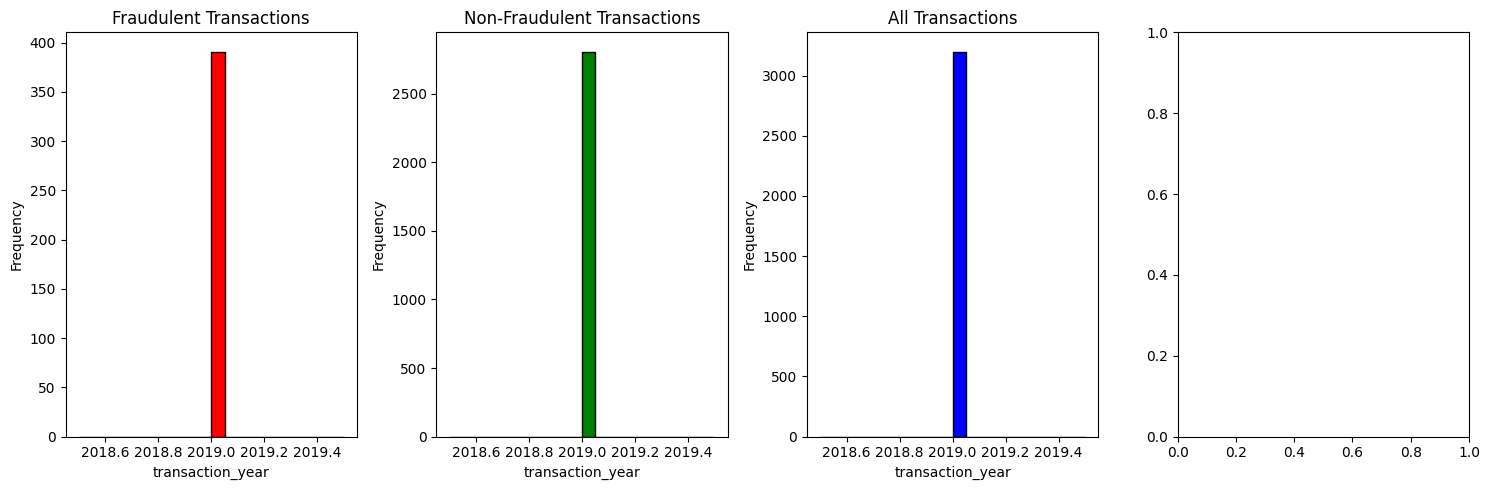

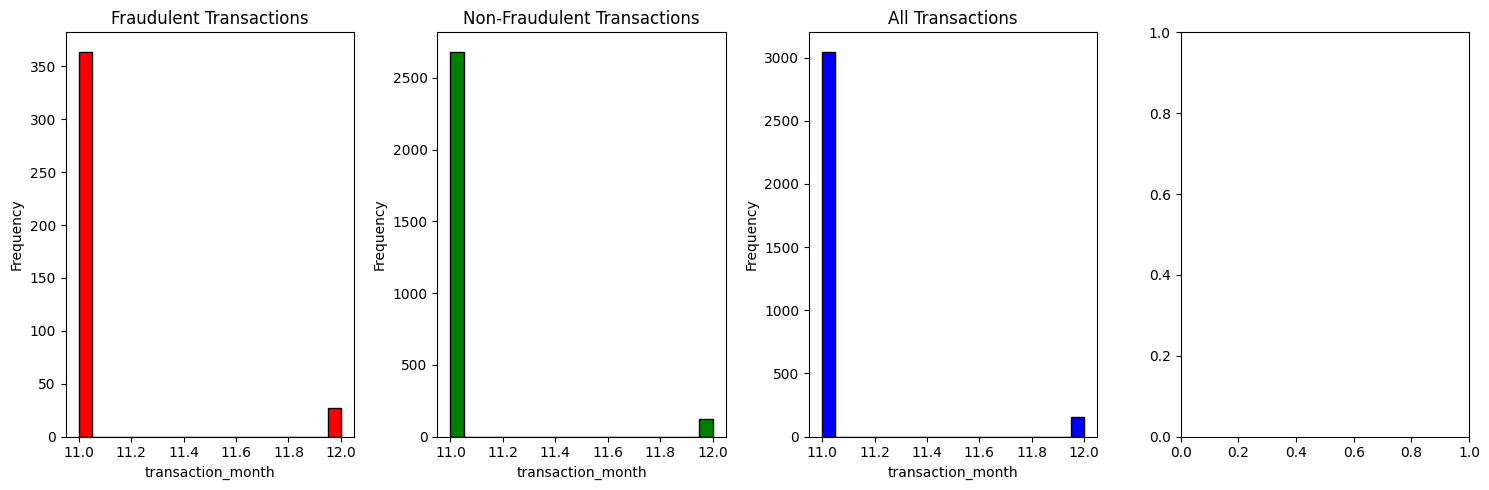

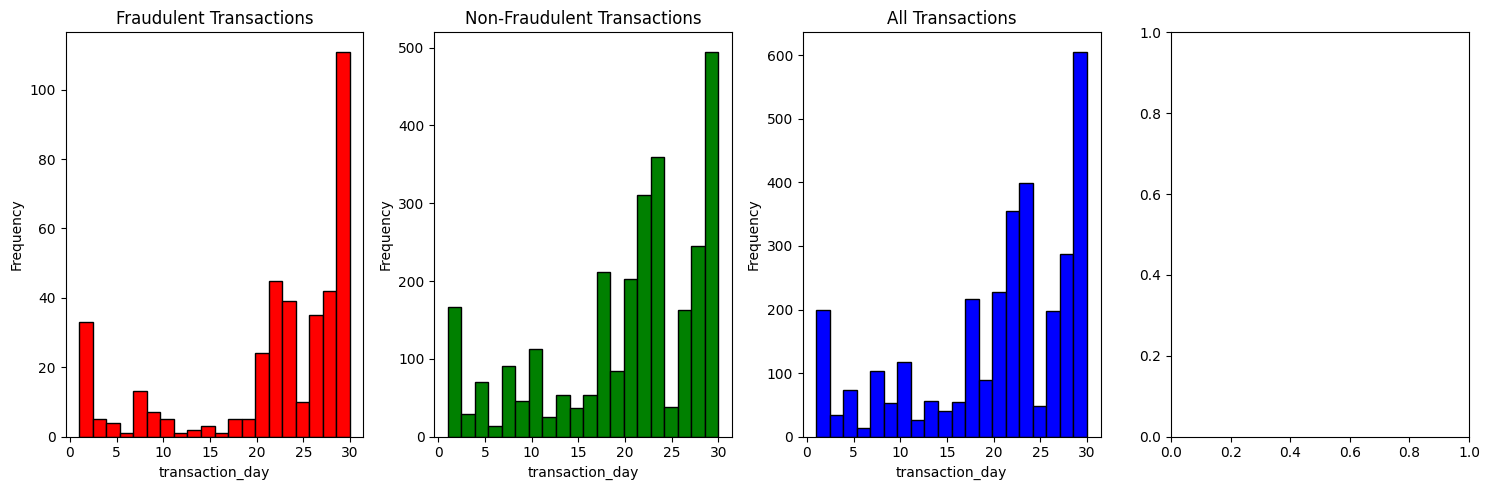

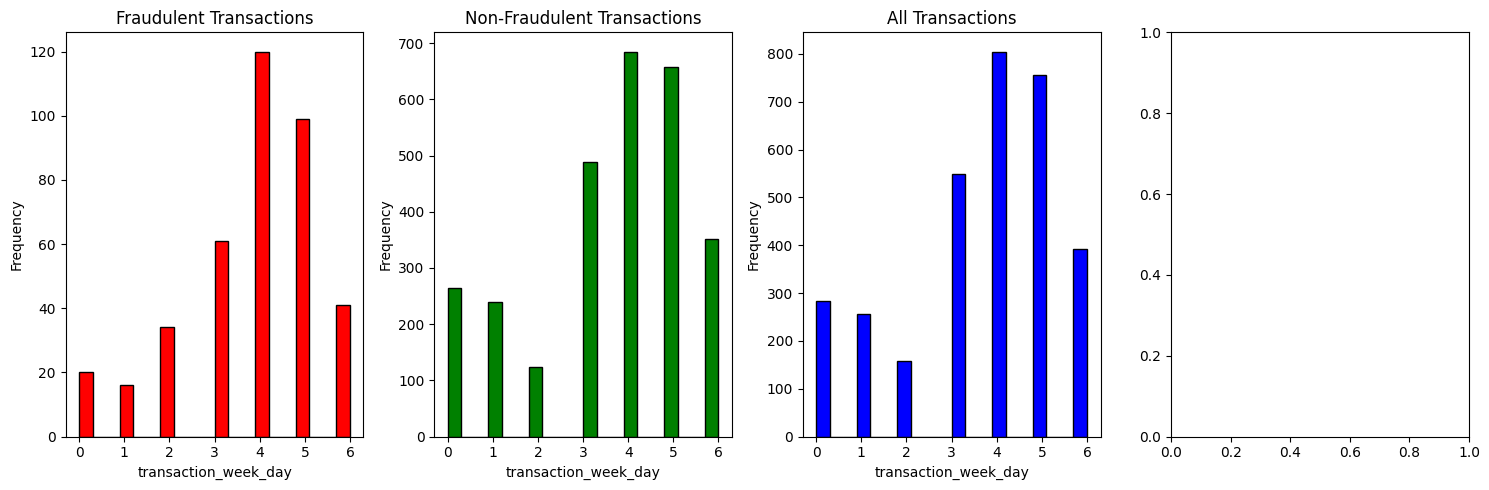

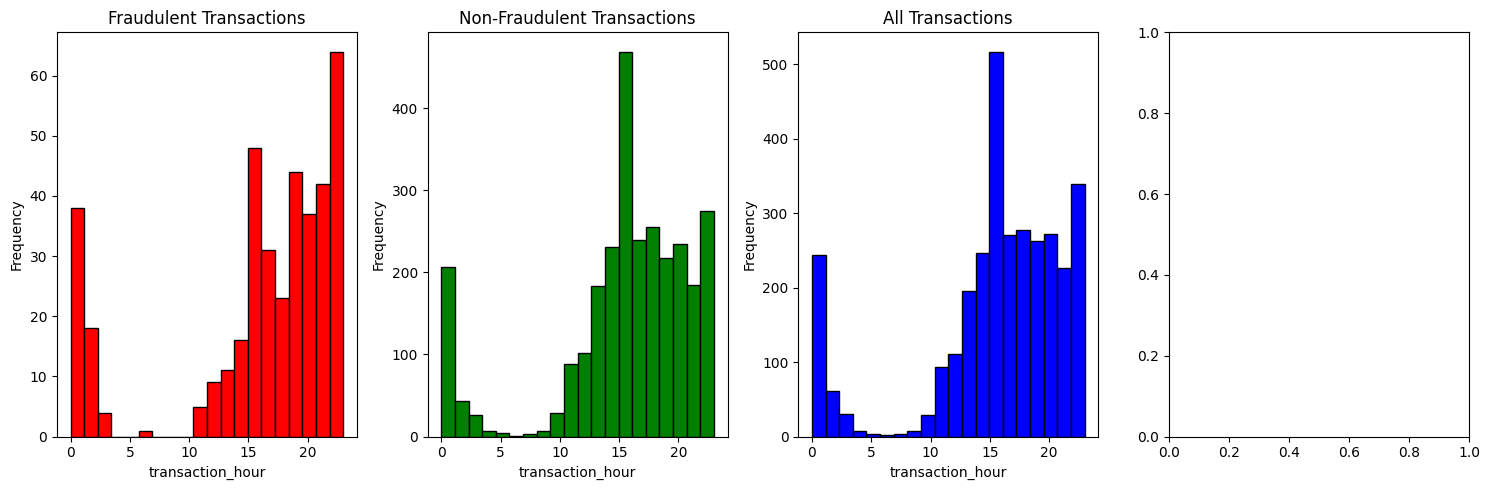

In [ ]:
getCbkTimeStats('transaction_year')
getCbkTimeStats('transaction_month')
getCbkTimeStats('transaction_day')
getCbkTimeStats('transaction_week_day')
getCbkTimeStats('transaction_hour')

In [1]:
# Identifying which transactions are most likely to be fraudulent
def getRatiosByDate(timeMeasurement):
  xvals = []
  yvals = []

  timeData = rawData.copy()
  timeData['transaction_date'] = pd.to_datetime(timeData['transaction_date'])
  timeData['transaction_year'] = timeData['transaction_date'].dt.year
  timeData['transaction_month'] = timeData['transaction_date'].dt.month
  timeData['transaction_day'] = timeData['transaction_date'].dt.day
  timeData['transaction_hour'] = timeData['transaction_date'].dt.hour
  timeData['transaction_week_day'] = timeData['transaction_date'].dt.dayofweek
  unique_values = timeData[timeMeasurement].unique()

  for value in unique_values:
    match timeMeasurement:
      case 'transaction_year':
        dataOnDate = timeData[timeData['transaction_date'].dt.year == value]
      case 'transaction_month':
        dataOnDate = timeData[timeData['transaction_date'].dt.month == value]
      case 'transaction_day':
        dataOnDate = timeData[timeData['transaction_date'].dt.day == value]
      case 'transaction_week_day':
        dataOnDate = timeData[timeData['transaction_date'].dt.dayofweek == value]
      case 'transaction_hour':
        dataOnDate = timeData[timeData['transaction_date'].dt.hour == value]
      case _:
          return
    fraud_percentage = (dataOnDate['has_cbk'] == 'TRUE').mean() * 100
    yvals.append(fraud_percentage)
    xvals.append(value)

  plt.figure(figsize=(4, 3))
  plt.bar(xvals, yvals, width=0.5)
  plt.xlabel(timeMeasurement)
  plt.ylabel('Frequency')
  plt.title('Percentage of fraudulent transactions by ' + timeMeasurement)
  plt.show()

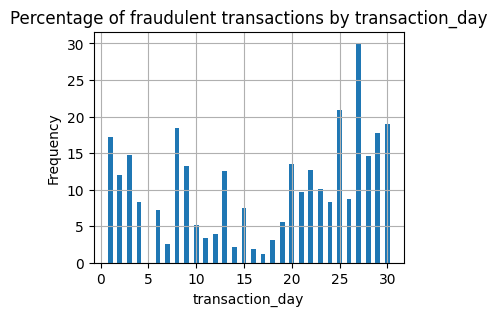

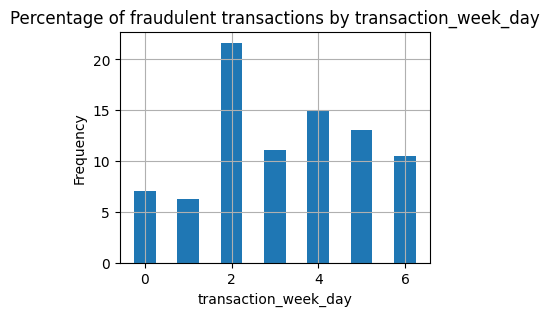

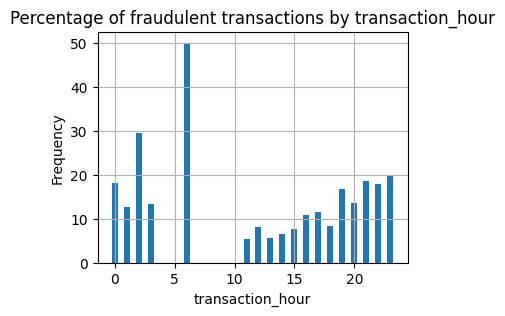

In [ ]:
getRatiosByDate('transaction_day')
getRatiosByDate('transaction_week_day')
getRatiosByDate('transaction_hour')